In [1]:
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise, nise
import numpy as np
import sklearn
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss
from sklearn.utils.extmath import squared_norm
from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression
import optuna
import pandas as pd
from scipy import stats
import math

import pandas as pd
import math
import random
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
import optuna, sklearn, sklearn.datasets

from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise

from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

In [2]:
import matplotlib.pyplot as plt
import math

In [3]:
class ImageScalarization(w_interface, single_interface, scalar_interface):
    def __init__(self, X, y, fair_feat):
        self.fair_feat = fair_feat
        self.fair_att = sorted(X[fair_feat].unique())
        self.__M = len(self.fair_att)
        self.X, self.y = X, y

    @property
    def M(self):
        return self.__M

    @property
    def feasible(self):
        return True

    @property
    def optimum(self):
        return True

    @property
    def objs(self):
        return self.__objs

    @property
    def x(self):
        return self.__x

    @property
    def w(self):
        return self.__w

    def optimize(self, w):
        """Calculates the a multiobjective scalarization"""
        if type(w) is int:
            self.__w = np.zeros(self.M)
            self.__w[w] = 0.95
        elif type(w) is np.ndarray and w.ndim==1 and w.size==self.M:
            self.__w = w
        else:
            raise('w is in the wrong format')
        #print('w', self.__w)
            
        lambd = math.exp(-100)
        fair_weight = self.__w
        
        sample_weight = self.X[self.fair_feat].replace({ff:fw/sum(self.X[self.fair_feat]==ff) for ff, fw in zip(self.fair_att,fair_weight)})
        prec = np.mean(sample_weight)
        reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight=None,
                                 penalty='l2', max_iter=10**5, tol=prec*10**-8, 
                                 C=1/lambd).fit(self.X, self.y, sample_weight=sample_weight.values)
        
        y_pred = reg.predict_proba(self.X)
        
        self.__objs = np.zeros(len(self.fair_att))
        for i, feat in enumerate(self.fair_att):
            fair_weight = np.zeros(len(self.fair_att))
            fair_weight[i] = 1
            sample_weight = self.X[self.fair_feat].replace({ff:fw for ff, fw in zip(self.fair_att,fair_weight)})
            self.__objs[i] = log_loss(self.y, y_pred, sample_weight=sample_weight)
        
        self.__x = reg
        return self

In [5]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [6]:
data = data.drop("Unnamed: 0", axis=1)

In [7]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

In [8]:
X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.5),stratify=categories_fair_class)

In [11]:
'''
err_image = monise(weightedScalar=ImageScalarization(X_train, y_train, fair_feature),
                 singleScalar=ImageScalarization(X_train, y_train, fair_feature),
                  nodeTimeLimit=5, targetSize=150,
                  targetGap=0, nodeGap=0.05, norm=False)
'''
err_image = nise(weightedScalar=ImageScalarization(X_train, y_train, fair_feature),
                 singleScalar=ImageScalarization(X_train, y_train, fair_feature),
                  targetSize=25, norm=False)


err_image.optimize()

2021-08-11 13:21:11,228 - moopt.nise - DEBUG: Finding 0th individual minima
2021-08-11 13:21:11,298 - moopt.nise - DEBUG: Finding 1th individual minima
2021-08-11 13:21:11,557 - moopt.nise - DEBUG: 3th solution - importance: 0.10920457172432449
2021-08-11 13:21:11,666 - moopt.nise - DEBUG: 4th solution - importance: 0.00971079816314131
2021-08-11 13:21:11,791 - moopt.nise - DEBUG: 5th solution - importance: 0.004296389281236811
2021-08-11 13:21:11,917 - moopt.nise - DEBUG: 6th solution - importance: 0.0021171485390749675
2021-08-11 13:21:12,065 - moopt.nise - DEBUG: 7th solution - importance: 0.0006276363801355553
2021-08-11 13:21:12,202 - moopt.nise - DEBUG: 8th solution - importance: 0.0005749988461953988
2021-08-11 13:21:12,348 - moopt.nise - DEBUG: 9th solution - importance: 0.0005385645347108809
2021-08-11 13:21:12,489 - moopt.nise - DEBUG: 10th solution - importance: 0.00035297708111993085
2021-08-11 13:21:12,614 - moopt.nise - DEBUG: 11th solution - importance: 0.000206185570148

In [12]:
loss = {"Raca1": [], "Raca0": []}

for solution in err_image.solutionsList:
    #sols.append(solution.x)
    #erro['Raca1'].append(solution.x.score(X_raca1_train, y_raca1_train))
    #erro['Raca0'].append(solution.x.score(X_raca0_train, y_raca0_train))
    #loss['Raca0'].append(log_loss(y_raca0_train, solution.x.predict_proba(X_raca0_train)))
    #loss['Raca1'].append(log_loss(y_raca1_train, solution.x.predict_proba(X_raca1_train)))
    loss['Raca0'].append(solution.objs[0])
    loss['Raca1'].append(solution.objs[1])

In [13]:
loss_dt = pd.DataFrame.from_dict(loss).sort_values(by='Raca0')

In [14]:
equal = ImageScalarization(X_train, y_train, fair_feature)
equal.optimize(np.array([0.5, 0.5]))

In [15]:
fig = plt.figure(figsize=(6,4))
plt.style.use('seaborn-pastel')

<Figure size 432x288 with 0 Axes>

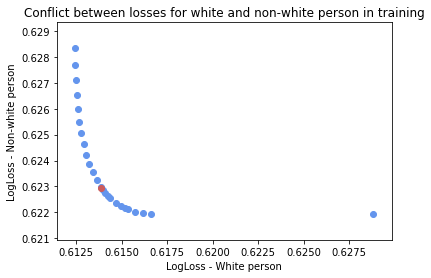

In [16]:
plt.scatter(loss_dt['Raca0'], loss_dt['Raca1'], color='cornflowerblue')
plt.scatter([equal.objs[0]], [equal.objs[1]], color='indianred')
#plt.plot(loss_dt['Raca0'], loss_dt['Raca1'])
plt.xlabel('LogLoss - White person')
plt.ylabel('LogLoss - Non-white person')
plt.xlim([loss_dt['Raca0'].min()-0.001, loss_dt['Raca0'].max()+0.001])
plt.ylim([loss_dt['Raca1'].min()-0.001, loss_dt['Raca1'].max()+0.001])
plt.title("Conflict between losses for white and non-white person in training")

plt.savefig("Conflit-LossesProPublica-notitle.png", dpi=600, bbox_inches='tight')
plt.show()

In [45]:
loss_dt

,Raca1,Raca0
0,0.612385,0.604901
27,0.611785,0.604904
40,0.611535,0.604912
11,0.611293,0.604925
39,0.611049,0.604943
20,0.610814,0.604966
38,0.610586,0.604995
6,0.610362,0.605030
37,0.610146,0.605069
19,0.609937,0.605114


In [74]:
import numpy as np

C_values = np.logspace(-100, 100, 500)

loss_reglog = {"White": [], "Non-white": []}

for C in C_values:
    model = LogisticRegression(C=C, max_iter=10**3, tol=10**-6)
    model.fit(X_train, y_train)
    
    loss_reglog['White'].append(log_loss(y_raca0_train, model.predict_proba(X_raca0_train)))
    loss_reglog['Non-white'].append(log_loss(y_raca1_train, model.predict_proba(X_raca1_train)))

In [75]:
loss_reglog_dt = pd.DataFrame.from_dict(loss_reglog).sort_values(by='White')

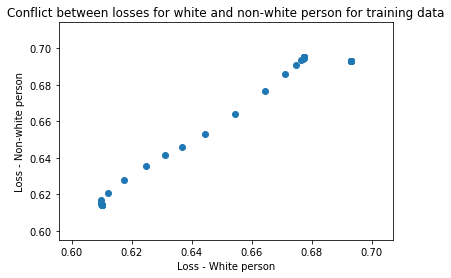

In [76]:
plt.scatter(loss_reglog_dt['White'], loss_reglog_dt['Non-white'])
#plt.plot(loss_dt['Raca0'], loss_dt['Raca1'])
plt.xlabel('Loss - White person')
plt.ylabel('Loss - Non-white person')
plt.title("Conflict between losses for white and non-white person for training data")
plt.show()